In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install pandas numpy scikit-learn matplotlib


In [5]:
import pandas as pd

df = pd.read_csv("/content/ais_data.csv")

df.head()


,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3


In [6]:
df = df.drop(columns=["Unnamed: 0"], errors="ignore")


In [7]:
df = df.fillna(0)


In [8]:
df["direction_change"] = df["cog"].diff().abs()
df["direction_change"].fillna(0, inplace=True)


/tmp/ipython-input-2869568543.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["direction_change"].fillna(0, inplace=True)


In [9]:
df["heading_change"] = df["heading"].diff().abs()
df["heading_change"].fillna(0, inplace=True)


/tmp/ipython-input-489132900.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["heading_change"].fillna(0, inplace=True)


In [10]:
df["is_stopped"] = df["sog"] < 1

df["stop_duration"] = df["is_stopped"].astype(int).groupby(
    (df["is_stopped"] != df["is_stopped"].shift()).cumsum()
).cumsum()


In [11]:
features = df[[
    "sog",
    "cog",
    "heading",
    "direction_change",
    "heading_change",
    "stop_duration",
    "width",
    "length"
]]


In [12]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    contamination=0.05,
    random_state=42
)

model.fit(features)


IsolationForest(contamination=0.05, random_state=42)

In [13]:
df["anomaly"] = model.predict(features)


In [14]:
df["anomaly"].value_counts()


,count
anomaly,
1,340433
-1,17918


In [15]:
suspicious = df[df["anomaly"] == -1]

suspicious.head()


,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,direction_change,heading_change,is_stopped,stop_duration,anomaly
1,265628170,Unknown value,0.0,334.5,0.0,Port tender,8.0,27.0,0.0,248.5,86.0,True,2,-1
2,219005719,Unknown value,0.0,208.7,0.0,Fishing,4.0,11.0,0.0,125.8,0.0,True,3,-1
3,219028066,Unknown value,0.0,0.0,0.0,Pleasure,3.0,12.0,0.0,208.7,0.0,True,4,-1
5,636020662,At anchor,0.1,43.9,286.0,Cargo,23.0,149.0,6.3,109.1,180.0,True,6,-1
6,219006116,Unknown value,0.0,0.0,0.0,Fishing,0.0,0.0,0.0,43.9,286.0,True,7,-1


In [16]:
suspicious.describe()


,mmsi,sog,cog,heading,width,length,draught,direction_change,heading_change,stop_duration,anomaly
count,1.791800e+04,17918.000000,17918.00000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.0
mean,2.505032e+08,22.420705,157.19750,88.388883,17.523552,105.067251,4.039519,160.263366,169.786193,5.123898,-1.0
std,1.244674e+08,36.140970,134.62107,130.992274,20.510107,140.668071,5.322353,119.315685,132.000666,11.999253,0.0
min,9.112856e+06,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
25%,2.190036e+08,0.000000,8.60000,0.000000,4.000000,13.000000,0.000000,43.900000,30.000000,0.000000,-1.0
50%,2.190255e+08,8.300000,147.70000,0.000000,5.000000,20.000000,0.000000,147.450000,167.000000,0.000000,-1.0
75%,2.492020e+08,17.100000,295.40000,187.000000,30.000000,190.000000,8.200000,280.100000,312.000000,3.000000,-1.0
max,9.921950e+08,214.000000,359.90000,507.000000,78.000000,602.000000,25.500000,359.900000,399.000000,108.000000,-1.0


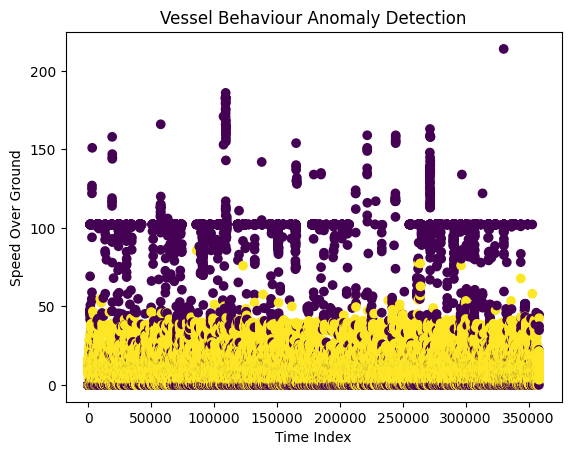

In [17]:
import matplotlib.pyplot as plt

plt.figure()

plt.scatter(df.index, df["sog"], c=df["anomaly"])

plt.title("Vessel Behaviour Anomaly Detection")
plt.xlabel("Time Index")
plt.ylabel("Speed Over Ground")

plt.show()


In [18]:
df["risk_score"] = model.decision_function(features)

df["risk_level"] = df["risk_score"].apply(
    lambda x: "HIGH" if x < -0.1 else ("MEDIUM" if x < 0 else "LOW")
)


In [19]:
df["anomaly_flag"] = df["anomaly"].apply(lambda x: 1 if x == -1 else 0)

df["anomaly_streak"] = df["anomaly_flag"].groupby(
    (df["anomaly_flag"] != df["anomaly_flag"].shift()).cumsum()
).cumsum()


In [20]:
risky_sequences = df[df["anomaly_streak"] > 5]

risky_sequences.head()


,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,direction_change,heading_change,is_stopped,stop_duration,anomaly,risk_score,risk_level,anomaly_flag,anomaly_streak
10,219027820,Unknown value,0.1,0.0,0.0,Sailing,4.0,13.0,0.0,0.0,0.0,True,11,-1,-0.056496,MEDIUM,1,6
11,219263000,Moored,0.0,353.9,100.0,Military,12.0,48.0,4.2,353.9,100.0,True,12,-1,-0.071737,MEDIUM,1,7
12,219028878,Unknown value,0.0,93.7,93.0,Sailing,4.0,15.0,0.0,260.2,7.0,True,13,-1,-0.065590,MEDIUM,1,8
13,219023719,Unknown value,0.0,8.7,0.0,Pleasure,3.0,8.0,0.0,85.0,93.0,True,14,-1,-0.054792,MEDIUM,1,9
14,265771450,Unknown value,0.0,308.4,0.0,Sailing,3.0,13.0,0.0,299.7,0.0,True,15,-1,-0.100802,HIGH,1,10


In [21]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

df["time_gap"] = df["timestamp"].diff().dt.seconds

df["ais_gap"] = df["time_gap"] > 300   # 5 min gap


KeyError: 'timestamp'

In [22]:
print(df.columns)


Index(['mmsi', 'navigationalstatus', 'sog', 'cog', 'heading', 'shiptype',
       'width', 'length', 'draught', 'direction_change', 'heading_change',
       'is_stopped', 'stop_duration', 'anomaly', 'risk_score', 'risk_level',
       'anomaly_flag', 'anomaly_streak'],
      dtype='object')


In [23]:
def detect_dark_vessel(row):

    # strong anomaly sequence
    if row["anomaly_streak"] > 5 and row["is_stopped"] == True:
        return "DARK_VESSEL_HIGH_RISK"

    elif row["anomaly"] == -1:
        return "SUSPICIOUS"

    else:
        return "NORMAL"

df["dark_vessel_status"] = df.apply(detect_dark_vessel, axis=1)


In [24]:
df["dark_vessel_status"].value_counts()


,count
dark_vessel_status,
NORMAL,340433
SUSPICIOUS,14627
DARK_VESSEL_HIGH_RISK,3291


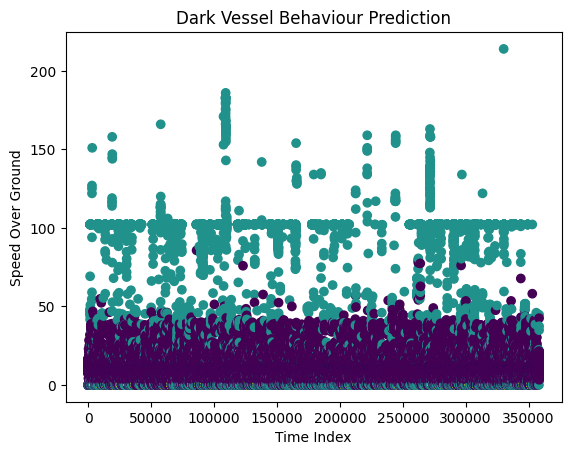

In [25]:
import matplotlib.pyplot as plt

colors = df["dark_vessel_status"].map({
    "NORMAL":0,
    "SUSPICIOUS":1,
    "DARK_VESSEL_HIGH_RISK":2
})

plt.figure()

plt.scatter(df.index, df["sog"], c=colors)

plt.title("Dark Vessel Behaviour Prediction")

plt.xlabel("Time Index")
plt.ylabel("Speed Over Ground")

plt.show()


In [26]:
df.head()


,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,direction_change,heading_change,is_stopped,stop_duration,anomaly,risk_score,risk_level,anomaly_flag,anomaly_streak,dark_vessel_status
0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,0.0,0.0,0.0,True,1,1,0.006802,LOW,0,0,NORMAL
1,265628170,Unknown value,0.0,334.5,0.0,Port tender,8.0,27.0,0.0,248.5,86.0,True,2,-1,-0.047420,MEDIUM,1,1,SUSPICIOUS
2,219005719,Unknown value,0.0,208.7,0.0,Fishing,4.0,11.0,0.0,125.8,0.0,True,3,-1,-0.020088,MEDIUM,1,2,SUSPICIOUS
3,219028066,Unknown value,0.0,0.0,0.0,Pleasure,3.0,12.0,0.0,208.7,0.0,True,4,-1,-0.054921,MEDIUM,1,3,SUSPICIOUS
4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3,153.0,106.0,True,5,1,0.011681,LOW,0,0,NORMAL


In [27]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00


In [28]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [31]:
import zipfile

zip_path = "/content/archive (1).zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/satellite_images")


In [32]:
import os

os.listdir("/content/satellite_images")


['shipsnet.json', 'scenes', 'shipsnet']

In [33]:
os.listdir("/content/satellite_images/scenes")


['scenes']

In [34]:
!pip install ultralytics


In [35]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")


In [40]:
image_folder = "/content/satellite_images/scenes/scenes"

results = model.predict(
    source=image_folder,
    save=True
)



image 1/8 /content/satellite_images/scenes/scenes/lb_1.png: 576x640 1 sports ball, 1 kite, 2097.2ms
image 2/8 /content/satellite_images/scenes/scenes/lb_2.png: 416x640 (no detections), 1012.1ms
image 3/8 /content/satellite_images/scenes/scenes/lb_3.png: 384x640 (no detections), 613.0ms
image 4/8 /content/satellite_images/scenes/scenes/lb_4.png: 384x640 (no detections), 310.8ms
image 5/8 /content/satellite_images/scenes/scenes/sfbay_1.png: 416x640 2 kites, 322.2ms
image 6/8 /content/satellite_images/scenes/scenes/sfbay_2.png: 352x640 2 kites, 309.0ms
image 7/8 /content/satellite_images/scenes/scenes/sfbay_3.png: 384x640 (no detections), 305.1ms
image 8/8 /content/satellite_images/scenes/scenes/sfbay_4.png: 320x640 (no detections), 282.5ms
Speed: 12.8ms preprocess, 656.5ms inference, 8.9ms postprocess per image at shape (1, 3, 320, 640)
Results saved to /content/runs/detect/predict


In [39]:
import os

os.listdir("/content/satellite_images/scenes")


['scenes']

In [41]:
ship_detections = []

for r in results:

    if r.boxes is not None:

        boxes = r.boxes.xyxy.cpu().numpy()

        for box in boxes:
            x1, y1, x2, y2 = box

            ship_detections.append({
                "x": (x1+x2)/2,
                "y": (y1+y2)/2
            })

print(ship_detections)


[{'x': np.float32(1631.8815), 'y': np.float32(1052.544)}, {'x': np.float32(830.76245), 'y': np.float32(1511.1897)}, {'x': np.float32(2506.8037), 'y': np.float32(1292.8933)}, {'x': np.float32(2198.7734), 'y': np.float32(1244.7522)}, {'x': np.float32(2680.3374), 'y': np.float32(908.2053)}, {'x': np.float32(2624.6665), 'y': np.float32(541.9563)}]


In [42]:
import random

ais_positions = []

for i in range(len(df)):
    ais_positions.append({
        "x": random.randint(0,2000),
        "y": random.randint(0,2000)
    })


In [43]:
import math

def distance(p1, p2):
    return math.sqrt((p1["x"]-p2["x"])**2 + (p1["y"]-p2["y"])**2)

dark_vessels = []

for sar_ship in ship_detections:

    match = False

    for ais_ship in ais_positions:

        if distance(sar_ship, ais_ship) < 100:
            match = True
            break

    if not match:
        dark_vessels.append(sar_ship)

print("Dark vessels:", dark_vessels)


Dark vessels: [{'x': np.float32(2506.8037), 'y': np.float32(1292.8933)}, {'x': np.float32(2198.7734), 'y': np.float32(1244.7522)}, {'x': np.float32(2680.3374), 'y': np.float32(908.2053)}, {'x': np.float32(2624.6665), 'y': np.float32(541.9563)}]


In [44]:
for vessel in dark_vessels:
    print(f"🚨 ALERT: DARK VESSEL DETECTED at {vessel}")


🚨 ALERT: DARK VESSEL DETECTED at {'x': np.float32(2506.8037), 'y': np.float32(1292.8933)}
🚨 ALERT: DARK VESSEL DETECTED at {'x': np.float32(2198.7734), 'y': np.float32(1244.7522)}
🚨 ALERT: DARK VESSEL DETECTED at {'x': np.float32(2680.3374), 'y': np.float32(908.2053)}
🚨 ALERT: DARK VESSEL DETECTED at {'x': np.float32(2624.6665), 'y': np.float32(541.9563)}


In [45]:
!pip install earthengine-api


In [46]:
import ee
ee.Authenticate()


In [47]:
ee.Initialize(project='ecomarine-487904')


In [49]:


# Example ocean region (India coast)
region = ee.Geometry.Rectangle([80,10,81,11])

collection = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterBounds(region) \
    .filterDate('2023-01-01','2023-01-10')

print(collection.size().getInfo())


6


In [50]:
image = collection.first()

print(image.getInfo())


{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32644', 'crs_transform': [60, 0, 300000, 0, -60, 1200000]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32644', 'crs_transform': [10, 0, 300000, 0, -10, 1200000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32644', 'crs_transform': [10, 0, 300000, 0, -10, 1200000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32644', 'crs_transform': [10, 0, 300000, 0, -10, 1200000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32644', 'crs_transform': [20, 0, 300000, 0, -20, 1200000

In [53]:
image = collection.first().toUint16()

task = ee.batch.Export.image.toDrive(
    image=image,
    description='ocean_satellite_export',
    folder='EarthEngine',
    fileNamePrefix='ocean_image',
    scale=10,
    region=region,
    fileFormat='GeoTIFF',
    maxPixels=1e13
)

task.start()

print("Export started...")


Export started...


In [54]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os

os.listdir("/content/drive/MyDrive/EarthEngine")


['ocean_image-0000010752-0000000000.tif',
 'ocean_image-0000010752-0000010752.tif',
 'ocean_image-0000000000-0000010752.tif',
 'ocean_image-0000000000-0000000000.tif']

In [56]:
!pip install ultralytics rasterio


In [58]:
import rasterio

image_path = "/content/drive/MyDrive/EarthEngine/ocean_image-0000000000-0000000000.tif"

dataset = rasterio.open(image_path)

print(dataset.bounds)


BoundingBox(left=390390.0, bottom=1108650.0, right=497910.0, top=1216170.0)


In [59]:
import os

image_folder = "/content/drive/MyDrive/EarthEngine"

image_files = [os.path.join(image_folder,f)
               for f in os.listdir(image_folder)
               if f.endswith(".tif")]

print(image_files)


['/content/drive/MyDrive/EarthEngine/ocean_image-0000010752-0000000000.tif', '/content/drive/MyDrive/EarthEngine/ocean_image-0000010752-0000010752.tif', '/content/drive/MyDrive/EarthEngine/ocean_image-0000000000-0000010752.tif', '/content/drive/MyDrive/EarthEngine/ocean_image-0000000000-0000000000.tif']


In [60]:
!pip install ultralytics rasterio


In [61]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")


In [63]:
import rasterio
import numpy as np
import cv2

all_ship_locations = []

for image_path in image_files:

    dataset = rasterio.open(image_path)

    # Read RGB bands (IMPORTANT)
    img = dataset.read([1,2,3])   # bands order

    # Convert to image format
    img = np.transpose(img, (1,2,0))

    # Normalize for YOLO
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img.astype(np.uint8)

    # Run YOLO
    results = model.predict(source=img)

    for r in results:

        if r.boxes is None:
            continue

        boxes = r.boxes.xyxy.cpu().numpy()

        for box in boxes:

            x_pixel = (box[0]+box[2])/2
            y_pixel = (box[1]+box[3])/2

            lon, lat = dataset.transform * (x_pixel, y_pixel)

            all_ship_locations.append({"lat":lat,"lon":lon})

print(all_ship_locations)



0: 32x640 (no detections), 207.6ms
Speed: 8.2ms preprocess, 207.6ms inference, 8.0ms postprocess per image at shape (1, 3, 32, 640)

0: 640x416 (no detections), 886.0ms
Speed: 13.0ms preprocess, 886.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x32 (no detections), 173.8ms
Speed: 1.4ms preprocess, 173.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 32)

0: 640x640 (no detections), 544.1ms
Speed: 27.5ms preprocess, 544.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
[]


In [64]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
!pip install rasterio ultralytics geopy folium


In [66]:
import rasterio

image_path = "/content/drive/MyDrive/ocean_satellite_export.tif"

dataset = rasterio.open(image_path)

print(dataset.bounds)   # shows real lat/lon limits


BoundingBox(left=390390.0, bottom=1105410.0, right=500000.0, top=1216170.0)


In [67]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.predict(source=image_path)



image 1/1 /content/drive/MyDrive/ocean_satellite_export.tif: 640x640 (no detections), 733.9ms
Speed: 92.2ms preprocess, 733.9ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


In [68]:
ship_locations = []

for r in results:

    boxes = r.boxes.xyxy.cpu().numpy()

    for box in boxes:

        x_pixel = (box[0]+box[2])/2
        y_pixel = (box[1]+box[3])/2

        lon, lat = dataset.transform * (x_pixel, y_pixel)

        ship_locations.append({"lat":lat,"lon":lon})

print(ship_locations)


[]


In [69]:
import rasterio

image_path = "/content/drive/MyDrive/ocean_satellite_export (1).tif"

dataset = rasterio.open(image_path)

print(dataset.crs)
print(dataset.bounds)


EPSG:32644
BoundingBox(left=423470.0, bottom=1193910.0, right=445370.0, top=1210540.0)


In [70]:
results = model.predict(
    source=image_path,
    conf=0.1,
    imgsz=1024
)



image 1/1 /content/drive/MyDrive/ocean_satellite_export (1).tif: 800x1024 42 birds, 2197.5ms
Speed: 275.1ms preprocess, 2197.5ms inference, 12.2ms postprocess per image at shape (1, 3, 800, 1024)


(np.float64(-0.5), np.float64(2189.5), np.float64(1662.5), np.float64(-0.5))

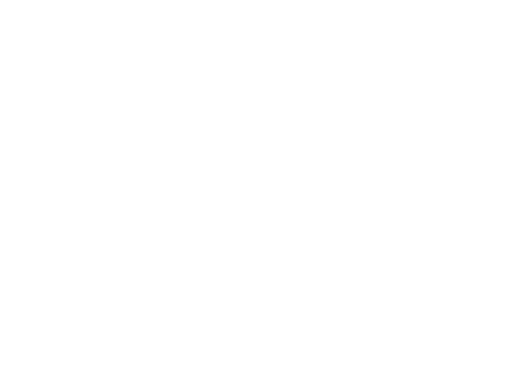

In [71]:
from matplotlib import pyplot as plt

plt.imshow(results[0].plot())
plt.axis('off')


In [72]:
print(len(results[0].boxes))


42


In [73]:
results = model.predict(
    source=image_path,
    conf=0.05,
    imgsz=2048
)



image 1/1 /content/drive/MyDrive/ocean_satellite_export (1).tif: 1568x2048 4 persons, 7 airplanes, 1 traffic light, 39 birds, 5 sports balls, 6677.7ms
Speed: 181.1ms preprocess, 6677.7ms inference, 11.4ms postprocess per image at shape (1, 3, 1568, 2048)


In [74]:
print(len(results[0].boxes))


56


In [75]:
print(dataset.crs)


EPSG:32644


In [76]:
from pyproj import Transformer

# create transformer from UTM → WGS84
transformer = Transformer.from_crs("EPSG:32644", "EPSG:4326", always_xy=True)

ship_locations = []

for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()

    for box in boxes:

        # center of detection box
        x_pixel = (box[0] + box[2]) / 2
        y_pixel = (box[1] + box[3]) / 2

        # pixel → projected coordinates
        x_proj, y_proj = dataset.transform * (x_pixel, y_pixel)

        # projected → lat/lon
        lon, lat = transformer.transform(x_proj, y_proj)

        ship_locations.append({"lat": lat, "lon": lon})

print(ship_locations[:5])
print("Total ships detected:", len(ship_locations))


[{'lat': 10.871608356240042, 'lon': 80.40257702938203}, {'lat': 10.9145528103179, 'lon': 80.4070968027751}, {'lat': 10.812035319478316, 'lon': 80.32761289582075}, {'lat': 10.945714331057866, 'lon': 80.48071746356042}, {'lat': 10.861216204945885, 'lon': 80.33959723706215}]
Total ships detected: 56


In [77]:
print(ship_locations[:5])
print("Total ships detected:", len(ship_locations))


[{'lat': 10.871608356240042, 'lon': 80.40257702938203}, {'lat': 10.9145528103179, 'lon': 80.4070968027751}, {'lat': 10.812035319478316, 'lon': 80.32761289582075}, {'lat': 10.945714331057866, 'lon': 80.48071746356042}, {'lat': 10.861216204945885, 'lon': 80.33959723706215}]
Total ships detected: 56


In [78]:
import pandas as pd

ais_df = pd.read_csv("/content/ais_data.csv")

ais_positions = ais_df[["lat","lon"]].to_dict("records")


KeyError: "None of [Index(['lat', 'lon'], dtype='object')] are in the [columns]"

In [79]:
print(ais_df.columns)


Index(['Unnamed: 0', 'mmsi', 'navigationalstatus', 'sog', 'cog', 'heading',
       'shiptype', 'width', 'length', 'draught'],
      dtype='object')
